## Music recommendation - KMeans Clustering Algorithm

### Import necessary libraries

In [49]:
import os
import boto3
import io
import sagemaker

%matplotlib inline 

import pandas as pd
import numpy as np
# import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sagemaker import KMeans
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
matplotlib.style.use('ggplot')
import pickle, gzip, urllib, json
import csv

In [28]:
!pip install -r requirements.txt

  Using cached altair-4.1.0-py3-none-any.whl (727 kB)
  Using cached openTSNE-0.6.1-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached scikit_learn-0.24.2-cp36-cp36m-manylinux2010_x86_64.whl (22.2 MB)
     |████████████████████████████████| 9.1 MB 19.5 MB/s            
     |████████████████████████████████| 292 kB 65.7 MB/s            
     |████████████████████████████████| 138 kB 74.3 MB/s            
     |████████████████████████████████| 366 kB 61.0 MB/s            
     |████████████████████████████████| 58 kB 10.7 MB/s            
     |████████████████████████████████| 164 kB 81.4 MB/s            
     |████████████████████████████████| 4.2 MB 70.5 MB/s            
     |████████████████████████████████| 170 kB 73.4 MB/s            
     |████████████████████████████████| 111 kB 77.0 MB/s            
  Preparing metadata (setup.py) ... done
  Using cached gitdb-4.0.9-py3-none-any.whl (63

The get_execution_role function retrieves the IAM role you created at the time you created your notebook instance.

In [8]:
from sagemaker import get_execution_role
role = get_execution_role()

In [9]:
role

'arn:aws:iam::334847460589:role/service-role/AmazonSageMaker-ExecutionRole-20220425T174946'

In [12]:
!python --version

Python 3.6.13


### Connect to AWS S3 and load the data

In [10]:
s3_client = boto3.client('s3')
data_bucket_name='music-rec-data'

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [13]:
obj_list=s3_client.list_objects(Bucket=data_bucket_name)
file=[]
for contents in obj_list['Contents']:
    file.append(contents['Key'])
print(file)

['2022_19_19_23_29_24_MPD_Extended.csv', '2022_20_20_00_58_35_Playlist_Feats_20000.csv', 'KMeans_K17_20000_sample_model.sav', 'MPD.csv', 'StdScaler.sav', 'openTSNETransformer.sav']


Grab the data from the CSV file in the bucket.

In [14]:
MPD_extended_data=file[0]
MPD_20k_features_data=file[1]
kmeans_k17_20k_model_file= file[2]
MPD_data=file[3]
std_scalar_data=file[4]
open_tsne_transformer_file=file[5]

In [15]:
# get mpd_extended data from s3 and convert to a pandas dataframe
response_mpd_extended = s3_client.get_object(Bucket=data_bucket_name, Key=MPD_extended_data)
response_body_mpd_extended = response_mpd_extended["Body"].read()
mpd_extended_df = pd.read_csv(io.BytesIO(response_body_mpd_extended), header=0, delimiter=",", low_memory=False) 

In [16]:
# get mpd_features_20k data from s3 and convert to a pandas dataframe
response_mpd_features = s3_client.get_object(Bucket=data_bucket_name, Key=MPD_20k_features_data)
response_body_mpd_features = response_mpd_features["Body"].read()
mpd_features_df = pd.read_csv(io.BytesIO(response_body_mpd_features), header=0, delimiter=",", low_memory=False) 

In [17]:
# get a peek at mpd_extended dataframe
mpd_extended_df.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,...,240,241,242,243,244,245,246,247,248,249
0,Throwbacks,False,0,1493424000,52,47,1,6,11532414,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Awesome Playlist,False,1,1506556800,39,23,1,5,11656470,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,korean,False,2,1505692800,64,51,1,18,14039958,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mat,False,3,1501027200,126,107,1,4,28926058,86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90s,False,4,1401667200,17,16,2,7,4335282,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
mpd_features_df.head()

,name,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Throwbacks,0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000
1,Awesome Playlist,1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231
2,korean,2,0.671062,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000
3,mat,3,0.514429,0.620902,5.103175,-9.618754,0.714286,0.067000,0.273514,0.203156,0.188278,0.451258,125.547627,229575.055556,3.952381
4,90s,4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176


### Load model, std_scalar and tsnetransformer pkl files

In [22]:
kmeans_model = pickle.loads(s3_client.get_object(Bucket=data_bucket_name, Key=kmeans_k17_20k_model_file)['Body'].read())
# self.tsne_transformer = pickle.load(open(tsne_path, 'rb'))
# self.scaler = pickle.load(open(scaler_path, 'rb'))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
kmeans_model

KMeans(n_clusters=17, random_state=0)

In [29]:
tsne_transformer = pickle.loads(s3_client.get_object(Bucket=data_bucket_name, Key=open_tsne_transformer_file)['Body'].read())

In [37]:
tsne_transformer

TSNEEmbedding([[-30.54404984,  -3.3135508 ],
               [ 22.80968393,  24.27873547],
               [-25.17905634,  10.28683536],
               ...,
               [ -2.72860871,   7.53187766],
               [ 20.54390781,  12.79169397],
               [-12.85596343,  35.80687949]])

In [30]:
scaler = pickle.loads(s3_client.get_object(Bucket=data_bucket_name, Key=std_scalar_data)['Body'].read())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [38]:
scaler

StandardScaler()

In [41]:
feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

scaled_data = scaler.transform(mpd_features_df[feat_cols_user])

In [50]:
scaled_data

array([[ 0.61285581,  1.08718413, -0.20177493, ..., -0.0207602 ,
        -0.38562989,  0.59049409],
       [-1.18161123,  0.44010557, -1.06191866, ...,  0.49754195,
         1.92610393, -1.76835992],
       [ 0.68586549,  0.4175371 , -0.25911785, ..., -0.90879619,
        -0.45773291,  0.59049409],
       ...,
       [ 0.42989733, -0.26438252,  0.27335208, ...,  0.51810596,
         1.03067027,  0.59049409],
       [-0.58001511, -0.57409341, -0.08872747, ..., -0.96984791,
         0.09546765,  0.2984455 ],
       [ 0.78765223, -0.46470067, -0.05082814, ..., -0.608362  ,
        -0.19037581,  0.21469627]])

In [51]:
feats_df = pd.DataFrame(scaled_data)
feats_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.612856,1.087184,-0.201775,0.996660,0.208011,0.192259,-0.913576,-0.473002,-0.007089,1.210086,-0.020760,-0.385630,0.590494
1,-1.181611,0.440106,-1.061919,-0.305130,-0.779607,-0.032644,-0.456511,1.291821,-0.187318,-0.100881,0.497542,1.926104,-1.768360
2,0.685865,0.417537,-0.259118,1.002980,-0.926207,0.063337,0.165333,-0.473291,-0.430553,0.596989,-0.908796,-0.457733,0.590494
3,-0.951192,-0.129978,-0.105293,-0.916527,0.349099,-0.458248,0.191017,1.129193,0.020639,-0.301443,0.573400,-0.151709,0.103746
4,-0.305220,0.094313,-2.714744,-0.113532,1.050391,-0.915264,-0.369455,0.168603,-0.485723,0.006686,0.868141,0.611446,-0.010782


In [42]:
df_opentsne = pd.DataFrame(tsne_transformer.transform(scaled_data),columns=['X','Y']) 
df_opentsne

,X,Y
0,-30.492081,-3.284703
1,14.582328,-0.450487
2,-25.191399,10.272353
3,12.570234,-1.446538
4,12.587242,-13.216509
...,...,...
19995,-21.571718,61.651856
19996,11.210131,22.198281
19997,-2.759643,7.527212
19998,20.192413,12.814304


<AxesSubplot:xlabel='X', ylabel='Y'>

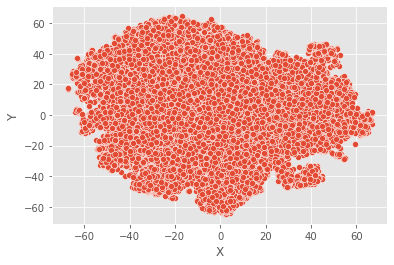

In [43]:
sns.scatterplot(x='X', y='Y', data=df_opentsne, legend=None)

### Lets import the data from S3 to Sagemaker

In [32]:
s3_mpd_extended = sagemaker.TrainingInput(s3_data='s3://{}/2022_19_19_23_29_24_MPD_Extended'.format(data_bucket_name), content_type='csv')

In [33]:
s3_mpd_extended

In [34]:
s3_mpd_features = sagemaker.TrainingInput(s3_data='s3://{}/2022_20_20_00_58_35_Playlist_Feats_20000'.format(data_bucket_name), content_type='csv')

In [35]:
s3_mpd_features

In [44]:
# kmeans_predictor = kmeans_model.deploy(initial_instance_count=1, 
#                                  instance_type='ml.t3.medium')

In [47]:
!tar -czvf model.tar.gz KMeans_K17_20000_sample_model.sav

KMeans_K17_20000_sample_model.sav


## Introducing the ezsmdeploy SDK

Ezsmdeploy Python SDK helps you easily deploy machine learning models and provides a rich set of features, such as the ability to pass one or more model files (yes, through multi-model deployments), to automatically choose an instance based on model size or based on a budget, and to load-test endpoints using an intuitive API. Ezsmdeploy uses the Amazon SageMaker Python SDK, which is an open source library for training and deploying machine learning models on Amazon SageMaker. This SDK, however, focuses on simplifying deployment from existing models. As such, this SDK is for you if:

    1. You have a serialized model (a pickle, joblib, JSON, TensorFlow SavedModel, PyTorch .pth, etc.) file and you want to deploy and test your model as an API endpoint.
    
    2. You have a model or multiple models stored as local files, in local folders, or in Amazon Simple Storage Service (Amazon S3) as tar files (model.tar.gz).
    
    3. You don’t want to create a custom Docker container for deployment and/or you don’t want to deal with Docker.
    
    4. You want to make use of advanced features, such as AWS Auto Scaling, Amazon Elastic Inference, multi-model endpoints, model inference data capture, and locust.io-based load testing, without the heavy lifting.
    
    5. You still want to have control over how to perform inference by passing in a Python script.


In [ ]:
# ezonsm = ezsmdeploy.Deploy(model = 'model.pth',
#               script = 'model_script.py',
#               requirements = ['numpy','torch','joblib'])

### Training and deployment

The built-in k-Means algorithm expects float32 as input format. Our dataframe is converted to float32 and used as training dataset. The model artifacts are stored onto S3. Training will be performed on a single c4.xlarge.

For now, let’s define k = 17 clusters for this training

In [56]:
feats_df = feats_df.astype('float32')
num_clusters = 17
output_location = 's3://' + data_bucket_name + '/model-artifacts'
kmeans = KMeans(role=role,
               train_instance_count=1,
               train_instance_type='ml.c4.xlarge',
               output_path=output_location,
               k=num_clusters)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [58]:
%%time
kmeans.fit(kmeans.record_set(feats_df.values), job_name="kmeans-k17")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-04-26 00:57:55 Starting - Starting the training job...
2022-04-26 00:58:19 Starting - Preparing the instances for trainingProfilerReport-1650934675: InProgress
.........
2022-04-26 00:59:42 Downloading - Downloading input data......
2022-04-26 01:00:48 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/26/2022 01:00:52 INFO 139944628422464] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_log_level': 'info', '_n

In [59]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!

In [87]:
preds=kmeans_predictor.predict(feats_df.values)

In [88]:
preds

[label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 12.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 1.345707654953003
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 15.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 3.4345405101776123
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 12.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 1.5503654479980469
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 8.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 2.2551846504211426
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 8.0
     }
   }
 }


In [86]:
feats_df.values[0]

array([ 0.6128558 ,  1.0871841 , -0.20177492,  0.9966596 ,  0.20801067,
        0.19225942, -0.9135759 , -0.47300163, -0.00708926,  1.2100859 ,
       -0.0207602 , -0.3856299 ,  0.5904941 ], dtype=float32)

In [66]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in preds]
predictions = pd.DataFrame(data=cluster_labels)

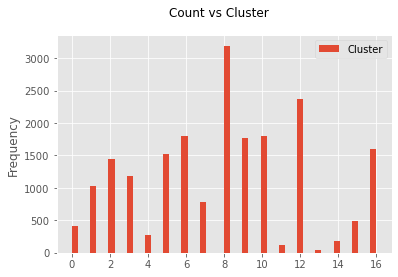

In [84]:
predictions = predictions.rename(columns={0: "Cluster"})
# hist = predictions.hist(bins=50, alpha=0.5)
ax = predictions.plot(kind='hist',bins=50,subplots=True,sharex=True,sharey=True,title='Count vs Cluster')

### Using this deployed model and accessing as an API endpoint

https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/